In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader

In [21]:
from pytube import YouTube
import os
mp3_url='https://www.youtube.com/watch?v=tp4fUH2E8uc'

yt = YouTube(mp3_url)
audio_stream = yt.streams.filter(only_audio=True).first()

outfile=audio_stream.download(output_path='.')
base,ext=os.path.splitext(outfile)
new_file=base+'.wav'
os.rename(outfile,new_file)


In [29]:
from pydub import AudioSegment
start_time=10
end_time=20

audio = AudioSegment.from_file('./output_audio.mp3', format='mp3')
segment = audio[start_time * 1000:end_time * 1000]  # Select the segment (in milliseconds)
segment.export('tttt.mp3', format='mp3')

<_io.BufferedRandom name='tttt.mp3'>

In [28]:
from pytube import YouTube
from moviepy.editor import *

mp3_url = 'https://www.youtube.com/watch?v=WpyfrixXBqU'

# Download the YouTube video using pytube
yt = YouTube(mp3_url)
video_stream = yt.streams.filter(file_extension='mp4').first()
video_stream.download(filename='output_video.mp4')

# Extract audio using moviepy
video = VideoFileClip('output_video.mp4')
audio = video.audio
audio.write_audiofile('output_audio.mp3')

#delete output_video.mp4
os.remove('output_video.mp4')


MoviePy - Writing audio in output_audio.mp3


MoviePy - Done.


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'output_video.mp4'

In [20]:
from pytube import YouTube
import os
yt = YouTube('https://www.youtube.com/watch?v=WpyfrixXBqU')
video = yt.streams.filter(only_audio=True).first()
destination = '.'
out_file = video.download(output_path=destination)
base, ext = os.path.splitext(out_file)
new_file = base + '.mp3'
os.rename(out_file, new_file)
print(yt.title + " has been successfully downloaded.")

Thinking Out Loud has been successfully downloaded.


(128, 431)


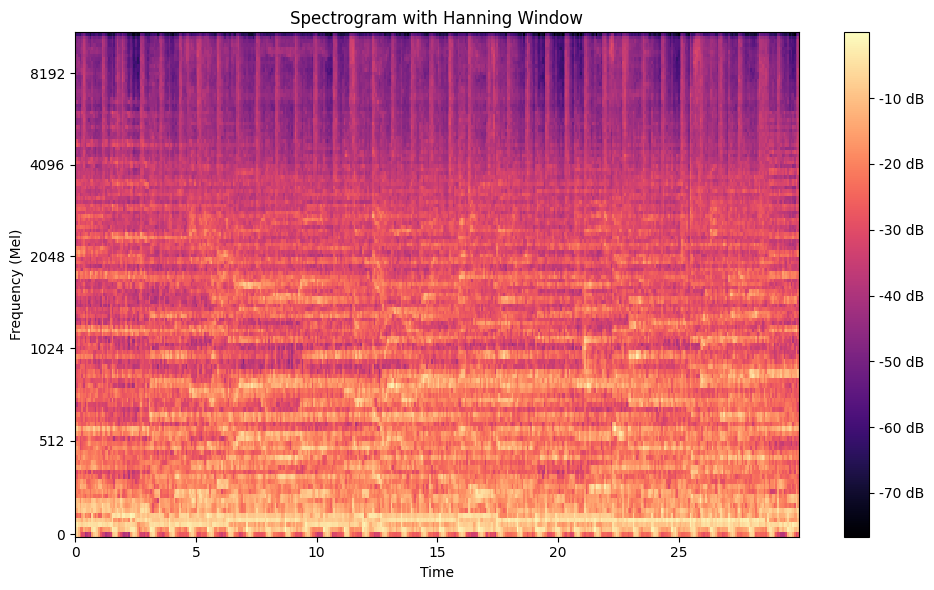

In [18]:
import os
import librosa
import numpy as np

os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'  # Set a cache directory
audio_file = 'data/1200songs2/0/Algo Rhythm One Sentence. Supervisor.mp3'
y, sr = librosa.load(audio_file)

n_fft = 3072  
hop_length = n_fft // 2 


spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, window='hann')

# Convert power spectrogram to dB
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

print(spectrogram_db.shape)
# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with Hanning Window')
plt.xlabel('Time')
plt.ylabel('Frequency (Mel)')
plt.tight_layout()
plt.show()

(161, 1292)


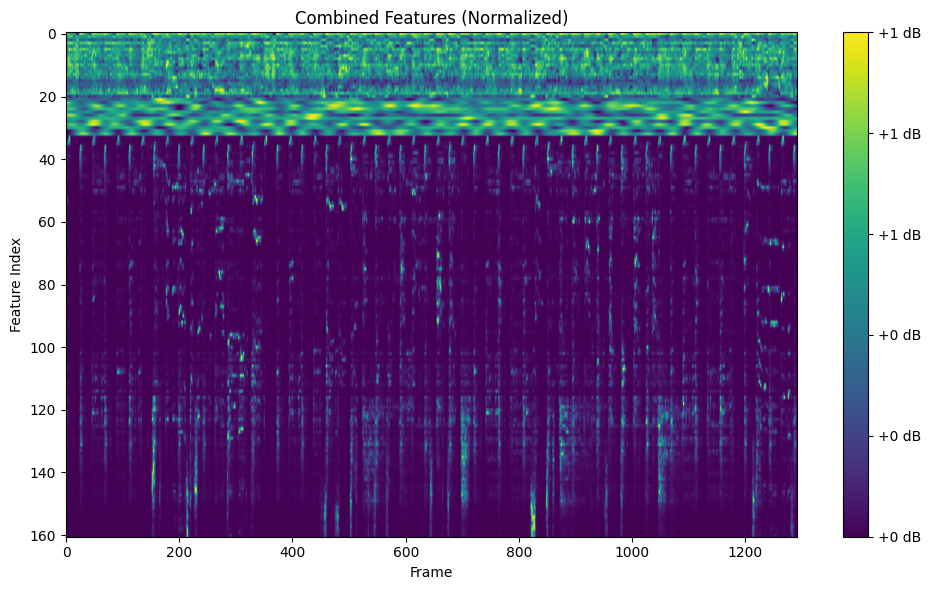

In [19]:
os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'
audio_file = 'data/1200songs2/1/1999 Prince.mp3'
from sklearn.preprocessing import minmax_scale


y, sr = librosa.load(audio_file)


mfccs = librosa.feature.mfcc(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
cens = librosa.feature.chroma_cens(y=y, sr=sr)


n_fft = 2048
hop_length = 512
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

combined_features = np.concatenate([mfccs, centroid, cens, mel_spectrogram], axis=0)

normalized_features = minmax_scale(combined_features, axis=1)  
print(normalized_features.shape)

plt.figure(figsize=(10, 6))
plt.imshow(normalized_features, aspect='auto', cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Feature Index')
plt.title('Combined Features (Normalized)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

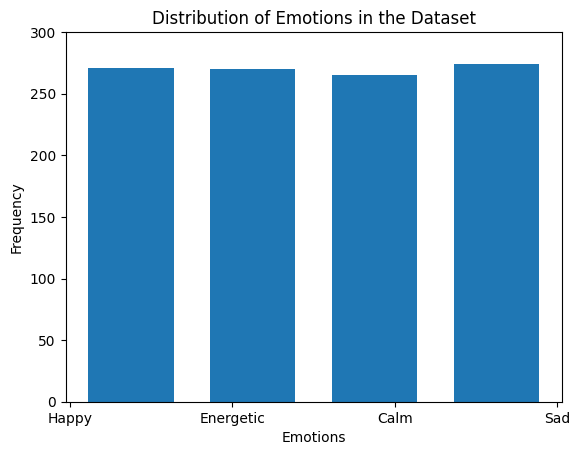

In [8]:
#read csv with pandas
data=pd.read_csv('data/278k_song_labelled.csv')

class SpotifyDataset(Dataset):
    def __init__(self, data,transform=None):
        self.features=data.columns[6:-1].to_list()
        self.transform=transform
        self.inputs = data[self.features].values
        self.labels=data['labels'].values
        self.classes=list(set(self.labels))

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        item = self.inputs[idx].astype('float32')  
        target = self.labels[idx]

        if self.transform:
            item = self.transform(item)

        return item, target



from sklearn.preprocessing import StandardScaler, MinMaxScaler




data2=pd.read_csv('data/1200_song_mapped.csv')
#train test split
from sklearn.model_selection import train_test_split
train,test=train_test_split(data2,test_size=0.1,random_state=42)

from torchvision.transforms import transforms
trainDataset=SpotifyDataset(train)
testDataset=SpotifyDataset(test)

scaler = StandardScaler()  # or MinMaxScaler()
trainDataset.inputs = scaler.fit_transform(trainDataset.inputs)
testDataset.inputs = scaler.transform(testDataset.inputs)

label_to_emotion = {
    0: 'Sad',
    1: 'Happy',
    2: 'Energetic',
    3: 'Calm'
}

trainDataset.labels = [label_to_emotion[label] for label in trainDataset.labels]
plt.hist(trainDataset.labels, bins=len(set(trainDataset.labels)), align='mid', rwidth=0.7)
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Distribution of Emotions in the Dataset')
plt.ylim(0, 300)
plt.show()


In [280]:
import torch.nn as nn
class ANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(ANN, self).__init__()
        layers = []
        last_dim = input_size
        for size in hidden_sizes:
            layers.append(nn.Linear(last_dim, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            last_dim = size
        layers.append(nn.Linear(last_dim, num_classes))
        self.net = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.net(x)
        out = self.softmax(out)
        return out

In [281]:
def train_model(model, num_epochs, train_loader, criterion, optimizer, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        if scheduler is not None:
            scheduler.step()


        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
                
    return model


In [315]:
from torch.optim.lr_scheduler import StepLR,CosineAnnealingLR



input_size = len(trainDataset.features)
hidden_sizes = [256,128,64,32]
num_classes = 4
learning_rate = 0.0048
batch_size = 8
num_epochs = 200

testLoader=DataLoader(dataset=testDataset,batch_size=batch_size,shuffle=True)
trainLoader=DataLoader(dataset=trainDataset,batch_size=batch_size,shuffle=True)

model=ANN(input_size=input_size,hidden_sizes=hidden_sizes,num_classes=num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adamax(model.parameters(),lr=learning_rate)
#scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1) 
model=train_model(model,num_epochs=num_epochs,train_loader=trainLoader,criterion=criterion,optimizer=optimizer,scheduler=scheduler)

Epoch [1/200], Loss: 1.2836
Epoch [2/200], Loss: 1.1193
Epoch [3/200], Loss: 1.0745
Epoch [4/200], Loss: 1.0473
Epoch [5/200], Loss: 1.0149
Epoch [6/200], Loss: 1.0149
Epoch [7/200], Loss: 1.0172
Epoch [8/200], Loss: 0.9959
Epoch [9/200], Loss: 0.9844
Epoch [10/200], Loss: 0.9760
Epoch [11/200], Loss: 0.9870
Epoch [12/200], Loss: 0.9811
Epoch [13/200], Loss: 0.9735
Epoch [14/200], Loss: 0.9702
Epoch [15/200], Loss: 0.9658
Epoch [16/200], Loss: 0.9692
Epoch [17/200], Loss: 0.9615
Epoch [18/200], Loss: 0.9582
Epoch [19/200], Loss: 0.9541
Epoch [20/200], Loss: 0.9547
Epoch [21/200], Loss: 0.9470
Epoch [22/200], Loss: 0.9575
Epoch [23/200], Loss: 0.9572
Epoch [24/200], Loss: 0.9553
Epoch [25/200], Loss: 0.9595
Epoch [26/200], Loss: 0.9550
Epoch [27/200], Loss: 0.9444
Epoch [28/200], Loss: 0.9519
Epoch [29/200], Loss: 0.9470
Epoch [30/200], Loss: 0.9536
Epoch [31/200], Loss: 0.9410
Epoch [32/200], Loss: 0.9427
Epoch [33/200], Loss: 0.9392
Epoch [34/200], Loss: 0.9459
Epoch [35/200], Loss: 0

In [316]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() 
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) 

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

test_model(model,testLoader)

Accuracy on test set: 80.00%


In [1]:
#model using SGDClassifier from sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(testDataset.inputs, testDataset.labels)
print("Testing accuracy:", clf.score(testDataset.inputs, testDataset.labels))
#end of model
#model using LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(),LogisticRegression())
clf.fit(testDataset.inputs, testDataset.labels)
print("Testing accuracy:", clf.score(testDataset.inputs, testDataset.labels))


Testing accuracy: 0.7833333333333333
Testing accuracy: 0.8333333333333334
